# Fine Tuning BERT for Sentiment Analysis with PyTorch

References:
- [Fine Tuning BERT for Sentiment Analysis with PyTorch](https://wellsr.com/python/fine-tuning-bert-for-sentiment-analysis-with-pytorch/)
- [Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv)

- [RuntimeError: CUDA out of memory during loss.backward()](https://discuss.pytorch.org/t/runtimeerror-cuda-out-of-memory-during-loss-backward/53450/6)
- [Forms - Colaboratory](https://colab.research.google.com/notebooks/forms.ipynb)
- [Plotting loss curve](https://discuss.pytorch.org/t/plotting-loss-curve/42632/5)
- [Estratégias eficazes para lidar com conjuntos de dados desbalanceados](https://medium.com/@daniele.santiago/estrat%C3%A9gias-eficazes-para-lidar-com-conjuntos-de-dados-desbalanceados-5b873894483b)
- [Aprenda a balancear seus dados com Undersampling e Oversampling em Python](https://medium.com/@daniele.santiago/aprenda-a-balancear-seus-dados-com-undersampling-e-oversampling-em-python-6fd87095d717#:~:text=J%C3%A1%20o%20over%2Dsampling%2C%20por,t%C3%A9cnicas%20foi%20explicitada%20neste%20artigo.)
- [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler.fit_resample)
- [REPRODUCIBILITY](https://pytorch.org/docs/stable/notes/randomness.html)

In [1]:
# @title Environment running
running_local = False
if running_local:
    running_colab = running_kaggle = False
else:
    running_colab = True  # @param {type:"boolean"}
    running_kaggle = not running_colab  # @param {type:"boolean"}

In [2]:
if running_colab:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


## Installing and Importing Required Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

## Config

In [4]:
RANDOM_SEED = 103
TEST_SIZE = 0.2
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5

TOKEN_MAX_LENGTH = 512
MODEL_PATH = "neuralmind/bert-base-portuguese-cased"

SAMPLE_REVIEWS = [
    "Empresa boa para trabalhar", # positive
    "Empresa ruim para trabalhar", # negative
    "Não tenho o que declarar", # neutral
]


if running_colab:
    GLASSDOOR_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-epoch_5.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-freezing-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/"
if running_kaggle:
    GLASSDOOR_MODEL_PATH = "/kaggle/working/bertimbau-glassdoor-reviews-epoch_5.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = (
        "/kaggle/working/bertimbau-glassdoor-reviews-freezing-epoch_5.bin"
    )
    PATH_TO_SAVE_MODEL = "/kaggle/working/"
if running_local:
    GLASSDOOR_MODEL_PATH = "./bertimbau-glassdoor-reviews-epoch_5.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = "./bertimbau-glassdoor-reviews-freezing-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "./train_model/"

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [6]:
torch.manual_seed(RANDOM_SEED)

In [7]:
random.seed(RANDOM_SEED)

In [8]:
np.random.seed(RANDOM_SEED)

## Importing and Preprocessing the Dataset

In [9]:
if running_colab:
    dataset = pd.read_csv(
        "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/data_preparation/glassdoor_reviews_annotated.csv"
    )
else:
    if running_kaggle:
        dataset = pd.read_csv(
            "/kaggle/input/glassdoor-reviews-annotated/glassdoor_reviews_annotated.csv"
        )
    else:
        dataset = pd.read_csv("../data_preparation/glassdoor_reviews_annotated.csv")

In [10]:
dataset.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",2023-12-15,5.0,1,0
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,2023-12-15,5.0,0,1


In [11]:
filtered_dataset = dataset.filter(["review_text", "sentiment"])

In [12]:
filtered_dataset.shape

(2532, 2)

In [13]:
filtered_dataset["sentiment"].value_counts()

sentiment
 1    1269
-1    1021
 0     242
Name: count, dtype: int64

In [14]:
num_labels = len(filtered_dataset["sentiment"].value_counts())

In [15]:
num_labels

3

In [16]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,-1
4,Única vantagem era o trabalho ser home office,0


Replace negative sentiment (-1) to 2, to avoid PyTorch errors.

In [17]:
filtered_dataset["sentiment"] = filtered_dataset["sentiment"].apply(
    lambda x: 2 if x == -1 else x
)

In [18]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,2
4,Única vantagem era o trabalho ser home office,0


Shuffle the data before splitting it into training and testing sets to remove any inherent ordering in the data that could bias the model's learning process.

In [19]:
filtered_dataset = filtered_dataset.sample(frac=1, random_state=RANDOM_SEED)

In [20]:
train_data, test_data = train_test_split(
    filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [21]:
train_data.shape

(2025, 2)

In [22]:
test_data.shape

(507, 2)

## Loading Bertimbau model

In [23]:
bertimbau = BertModel.from_pretrained(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [24]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Create a PyTorch Dataset

In [27]:
class GlassdoorReviewsDataset(Dataset):
    def __init__(self, data, tokenizer, token_max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = token_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["review_text"]
        labels = self.data.iloc[index][["sentiment"]].values.astype(int)

        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=False,
            # max_length=self.max_length,
        )
        input_ids = encoding["input_ids"][0]
        attention_mask = encoding["attention_mask"][0]

        # resize the tensors to the same size
        input_ids = nn.functional.pad(
            input_ids, (0, self.max_length - input_ids.shape[0]), value=0
        )
        attention_mask = nn.functional.pad(
            attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0
        )

        return input_ids, attention_mask, torch.tensor(labels)

In [28]:
train_dataset = GlassdoorReviewsDataset(train_data, tokenizer, TOKEN_MAX_LENGTH)
test_dataset = GlassdoorReviewsDataset(test_data, tokenizer, TOKEN_MAX_LENGTH)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Creating a PyTorch Model

In [30]:
classifier = nn.Sequential(
    nn.Linear(bertimbau.config.hidden_size, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, num_labels),
)

In [32]:
class GlassdoorReviewsClassifier(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_PATH)
        self.classifier = classifier


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

In [33]:
class GlassdoorReviewsClassifierFreezing(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifierFreezing, self).__init__()

        for param in bertimbau.parameters():
            param.requires_grad = False

        self.bert = BertModel.from_pretrained(MODEL_PATH)
        self.classifier = classifier

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

## Model training functions

In [34]:
def train(model, data_loader, loss_fun, optimizer, n_total_steps):
    model.train()

    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)

        loss = loss_fun(logits, labels)

        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        if (i + 1) % BATCH_SIZE == 0:
            print(
                f"Training Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
            )

    return running_loss / len(data_loader)

In [35]:
def test(model, data_loader, loss_fun, n_total_steps):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fun(logits, labels)

            loss_value = loss.item()
            running_loss += loss_value

            if (i + 1) % BATCH_SIZE == 0:
                print(
                    f"Evaluating Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
                )

    return running_loss / len(data_loader)

In [36]:
def show_loss(train_loss_per_epoch, test_loss_per_epoch, title):
    epochs = range(1, len(train_loss_per_epoch) + 1)

    train_data = {"epoch": epochs, "loss": train_loss_per_epoch, "type": "Train"}
    test_data = {"epoch": epochs, "loss": test_loss_per_epoch, "type": "Test"}
    df_loss = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)])

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_loss, x="epoch", y="loss", hue="type", marker="o")

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # plt.grid(True)
    plt.legend(title="Loss Type")
    plt.show()

In [37]:
def start_training(model, train_loader, loss_fun, optimizer, epochs, n_total_steps):
    train_losses = []
    test_losses = []

    for t in range(epochs):
        print(f"{'-'*20} Epoch: {t + 1}/{epochs} {'-'*20}")

        train_loss = train(model, train_loader, loss_fun, optimizer, n_total_steps)
        train_losses.append(train_loss)

        print("")

        test_loss = test(model, test_loader, loss_fun, n_total_steps)
        test_losses.append(test_loss)

        print(f"\nTrain Loss: {train_loss}, \t\t Test Loss: {test_loss}")
        print("\n\n")

    return train_losses, test_losses

## Model Evaluation functions

In [38]:
def evaluate_model(model, test_loader, device):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            _, predictions = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    return all_labels, all_preds

In [39]:
def show_confusion_matrix(all_labels, all_preds, normalize=None):
    cm = confusion_matrix(all_labels, all_preds, normalize=normalize)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [40]:
def predict_reviews(model, reviews) -> None:
    class_names = ["neutral", "positive", "negative"]
    for review in reviews:
        encoded_review = tokenizer.encode_plus(
            review,
            max_length=TOKEN_MAX_LENGTH,
            add_special_tokens=True,
            return_token_type_ids=False,
            # pad_to_max_length=True, # deprecated
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        input_ids = encoded_review["input_ids"].to(device)
        attention_mask = encoded_review["attention_mask"].to(device)

        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)
        probs = nn.functional.softmax(output, dim=1)

        print(f"Review text: {review}")
        # print(probs)
        print(pd.DataFrame(probs.tolist()[0], class_names)[0])
        print("\n")

    return None

## Training the Model (without oversampling)

In [41]:
model = GlassdoorReviewsClassifier(num_labels).to(device)
model_freezing = GlassdoorReviewsClassifierFreezing(num_labels).to(device)

In [42]:
loss_fun = nn.CrossEntropyLoss()

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer_freezing = torch.optim.Adam(model_freezing.parameters(), lr=LEARNING_RATE)

In [44]:
n_total_steps = len(train_loader)
n_total_steps

127

### Training Model without freezing BERT Layers

In [45]:
train_losses, test_losses = start_training(
    model, train_loader, loss_fun, optimizer, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/127, 		 loss = 1.0283
Training Batch 32/127, 		 loss = 1.0164
Training Batch 48/127, 		 loss = 0.7934
Training Batch 64/127, 		 loss = 0.9133
Training Batch 80/127, 		 loss = 0.7232
Training Batch 96/127, 		 loss = 0.8426
Training Batch 112/127, 		 loss = 0.4852

Evaluating Batch 16/127, 		 loss = 0.5884
Evaluating Batch 32/127, 		 loss = 0.3577

Train Loss: 0.7823926102458023, 		 Test Loss: 0.4486784376204014



-------------------- Epoch: 2/5 --------------------
Training Batch 16/127, 		 loss = 0.2996
Training Batch 32/127, 		 loss = 0.2565
Training Batch 48/127, 		 loss = 0.2875
Training Batch 64/127, 		 loss = 0.4945
Training Batch 80/127, 		 loss = 0.4591
Training Batch 96/127, 		 loss = 0.2701
Training Batch 112/127, 		 loss = 0.2240

Evaluating Batch 16/127, 		 loss = 0.5004
Evaluating Batch 32/127, 		 loss = 0.1304

Train Loss: 0.34690046005361663, 		 Test Loss: 0.30257522431202233



-------------------- E

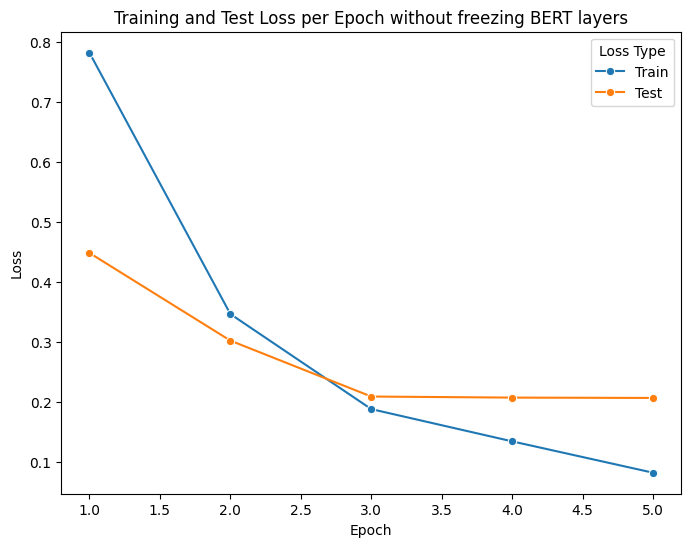

In [46]:
show_loss(train_losses, test_losses, title="Training and Test Loss per Epoch without freezing BERT layers")

#### Evaluating the Model

In [47]:
all_labels, all_preds = evaluate_model(model, test_loader, device)

In [48]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78        51
           1       0.95      0.97      0.96       269
           2       0.94      0.95      0.94       187

    accuracy                           0.94       507
   macro avg       0.91      0.88      0.89       507
weighted avg       0.94      0.94      0.94       507



In [49]:
print(accuracy_score(all_labels, all_preds))

0.9368836291913215


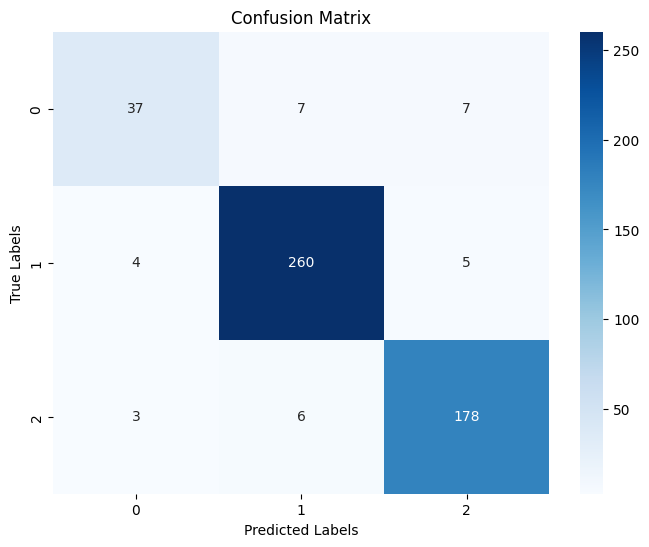

In [50]:
show_confusion_matrix(all_labels, all_preds)

In [51]:
# show_confusion_matrix(all_labels, all_preds, normalize="true")

#### Saving the model

In [65]:
torch.save(model.state_dict(), f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-epoch_{EPOCHS}.bin")

#### Loading the model

In [53]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_MODEL_PATH, map_location=device))
loaded_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

#### Sample prediction

In [54]:
predict_reviews(model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.006593
positive    0.988689
negative    0.004718
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.017018
positive    0.015703
negative    0.967279
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.918160
positive    0.029006
negative    0.052834
Name: 0, dtype: float64




### Training Model freezing BERT Layers

In [55]:
train_losses, test_losses = start_training(
    model_freezing, train_loader, loss_fun, optimizer_freezing, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/127, 		 loss = 0.5372
Training Batch 32/127, 		 loss = 0.4611
Training Batch 48/127, 		 loss = 0.2219
Training Batch 64/127, 		 loss = 0.1776
Training Batch 80/127, 		 loss = 0.3635
Training Batch 96/127, 		 loss = 0.3699
Training Batch 112/127, 		 loss = 0.2755

Evaluating Batch 16/127, 		 loss = 0.1507
Evaluating Batch 32/127, 		 loss = 0.0704

Train Loss: 0.3698675376399765, 		 Test Loss: 0.30022662214469165



-------------------- Epoch: 2/5 --------------------
Training Batch 16/127, 		 loss = 0.0748
Training Batch 32/127, 		 loss = 0.1461
Training Batch 48/127, 		 loss = 0.0388
Training Batch 64/127, 		 loss = 0.4459
Training Batch 80/127, 		 loss = 0.0492
Training Batch 96/127, 		 loss = 0.2029
Training Batch 112/127, 		 loss = 0.0453

Evaluating Batch 16/127, 		 loss = 0.2182
Evaluating Batch 32/127, 		 loss = 0.2620

Train Loss: 0.15691454523778336, 		 Test Loss: 0.200679314089939



-------------------- Ep

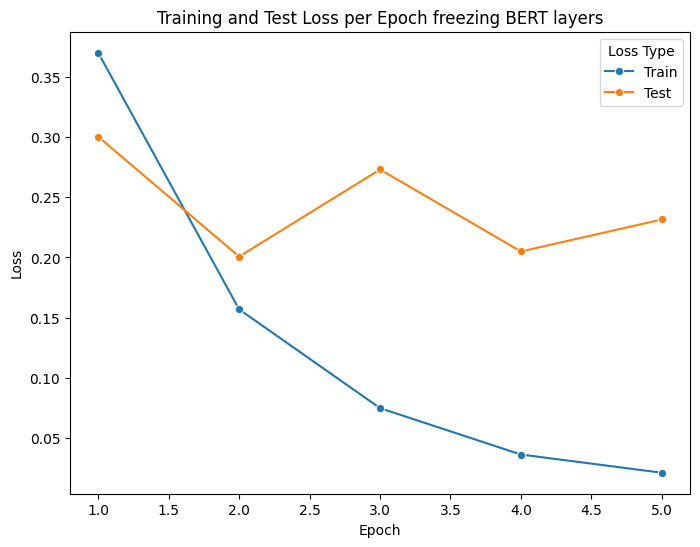

In [56]:
show_loss(train_losses, test_losses, title="Training and Test Loss per Epoch freezing BERT layers")

#### Evaluating the Model

In [105]:
all_labels, all_preds = evaluate_model(model_freezing, test_loader, device)

In [106]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.73      0.88      0.80        51
           1       0.96      0.95      0.96       269
           2       0.96      0.93      0.94       187

    accuracy                           0.93       507
   macro avg       0.88      0.92      0.90       507
weighted avg       0.94      0.93      0.93       507



In [107]:
print(accuracy_score(all_labels, all_preds))

0.9329388560157791


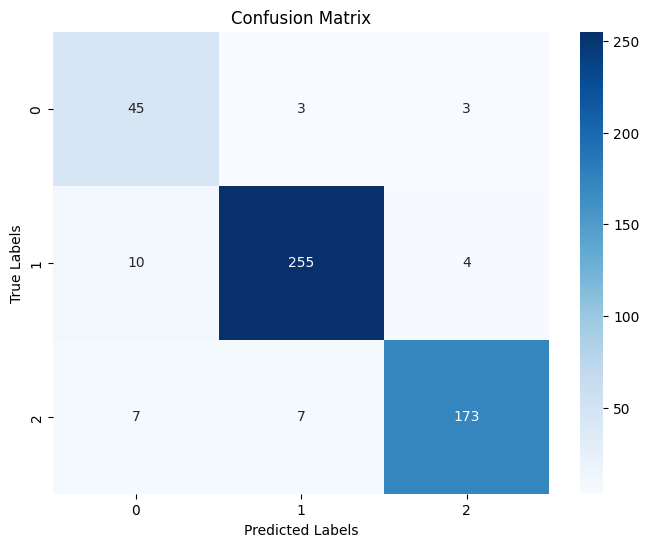

In [108]:
show_confusion_matrix(all_labels, all_preds)

In [109]:
# show_confusion_matrix(all_labels, all_preds, normalize="true")

#### Saving the model

In [110]:
torch.save(model.state_dict(), f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-freezing-epoch_{EPOCHS}.bin")

#### Loading the model

In [111]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_FREEZING_MODEL_PATH, map_location=device))
loaded_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

##### Sample prediction

In [112]:
predict_reviews(loaded_model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.000020
positive    0.999963
negative    0.000017
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.000190
positive    0.000448
negative    0.999362
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.999724
positive    0.000082
negative    0.000194
Name: 0, dtype: float64




## Training the model (with oversampling)

### Oversampling

In [70]:
def oversampling(train_df, minority_class=0, majority_classes=[1, 2]):
    # Desired number of samples for the minority class
    oversample_size = (
        train_df[train_df["sentiment"] == 0]["sentiment"].value_counts()[0] * 3
    )

    oversampler = RandomOverSampler(sampling_strategy={minority_class: oversample_size})
    X_res, y_res = oversampler.fit_resample(
        train_df[["review_text"]], train_df["sentiment"]
    )

    y_res_df = pd.DataFrame({"sentiment": y_res})
    resampled_df = pd.concat([X_res, y_res_df], axis=1)
    resampled_df.reset_index(drop=True, inplace=True)

    resampled_minority_df = resampled_df[resampled_df["sentiment"] == minority_class]

    # Concatenate the oversampled minority class with the majority class
    oversampled_df = pd.concat([train_df, resampled_minority_df])

    # Shuffle the DataFrame to randomize the order of samples
    oversampled_df = oversampled_df.sample(
        frac=1, random_state=RANDOM_SEED
    ).reset_index(drop=True)
    return oversampled_df

In [71]:
filtered_dataset.shape

(2532, 2)

In [72]:
filtered_dataset["sentiment"].value_counts()

sentiment
1    1269
2    1021
0     242
Name: count, dtype: int64

In [73]:
oversampled_filtered_dataset = oversampling(filtered_dataset)

In [74]:
oversampled_filtered_dataset.shape

(3258, 2)

In [75]:
oversampled_filtered_dataset["sentiment"].value_counts()

sentiment
1    1269
2    1021
0     968
Name: count, dtype: int64

### Training the Model

In [76]:
oversampled_train_data, oversampled_test_data = train_test_split(
    oversampled_filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [77]:
oversampled_train_dataset = GlassdoorReviewsDataset(
    oversampled_train_data, tokenizer, TOKEN_MAX_LENGTH
)

oversampled_test_dataset = GlassdoorReviewsDataset(
    oversampled_test_data, tokenizer, TOKEN_MAX_LENGTH
)

In [78]:
oversampled_train_loader = DataLoader(
    oversampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
oversampled_test_loader = DataLoader(
    oversampled_test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [79]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model_freezing = GlassdoorReviewsClassifierFreezing(num_labels).to(device)

In [80]:
loss_fun = nn.CrossEntropyLoss()

In [81]:
oversampled_optimizer = torch.optim.Adam(
    oversampled_model.parameters(), lr=LEARNING_RATE
)
oversampled_optimizer_freezing = torch.optim.Adam(
    oversampled_model_freezing.parameters(), lr=LEARNING_RATE
)

In [82]:
n_total_steps = len(oversampled_train_loader)
n_total_steps

163

#### Train without freezing

In [83]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer,
    EPOCHS,
    n_total_steps,
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/163, 		 loss = 0.6271
Training Batch 32/163, 		 loss = 0.3280
Training Batch 48/163, 		 loss = 0.3559
Training Batch 64/163, 		 loss = 0.5761
Training Batch 80/163, 		 loss = 0.2772
Training Batch 96/163, 		 loss = 0.4054
Training Batch 112/163, 		 loss = 0.0816
Training Batch 128/163, 		 loss = 0.1860
Training Batch 144/163, 		 loss = 0.3226
Training Batch 160/163, 		 loss = 0.2640

Evaluating Batch 16/163, 		 loss = 0.2387
Evaluating Batch 32/163, 		 loss = 0.0439

Train Loss: 0.32985912752480595, 		 Test Loss: 0.12197658320656046



-------------------- Epoch: 2/5 --------------------
Training Batch 16/163, 		 loss = 0.2186
Training Batch 32/163, 		 loss = 0.0262
Training Batch 48/163, 		 loss = 0.0225
Training Batch 64/163, 		 loss = 0.0134
Training Batch 80/163, 		 loss = 0.2164
Training Batch 96/163, 		 loss = 0.0277
Training Batch 112/163, 		 loss = 0.0137
Training Batch 128/163, 		 loss = 0.0159
Training Bat

##### Evaluating the Model

In [84]:
len(oversampled_train_losses)

5

In [85]:
len(oversampled_test_losses)

5

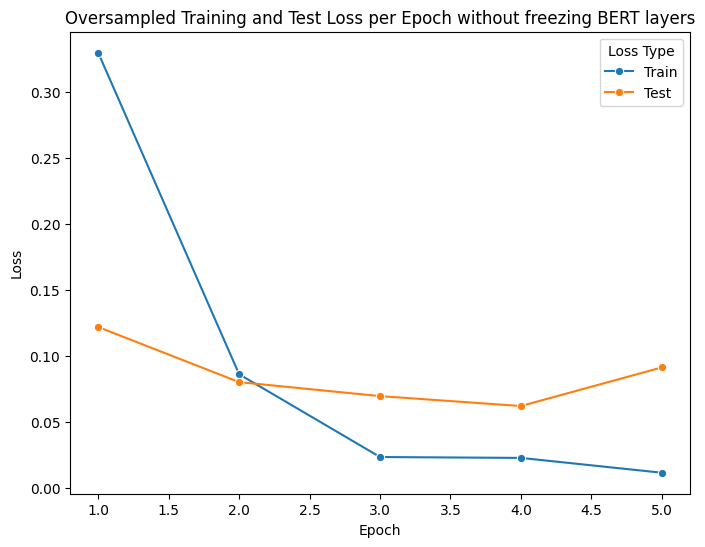

In [86]:
show_loss(oversampled_train_losses, oversampled_test_losses, title="Oversampled Training and Test Loss per Epoch without freezing BERT layers")

In [87]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model, oversampled_test_loader, device
)

In [88]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       197
           1       0.93      0.96      0.94       256
           2       0.98      0.86      0.92       199

    accuracy                           0.94       652
   macro avg       0.94      0.93      0.93       652
weighted avg       0.94      0.94      0.94       652



In [89]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

0.9355828220858896


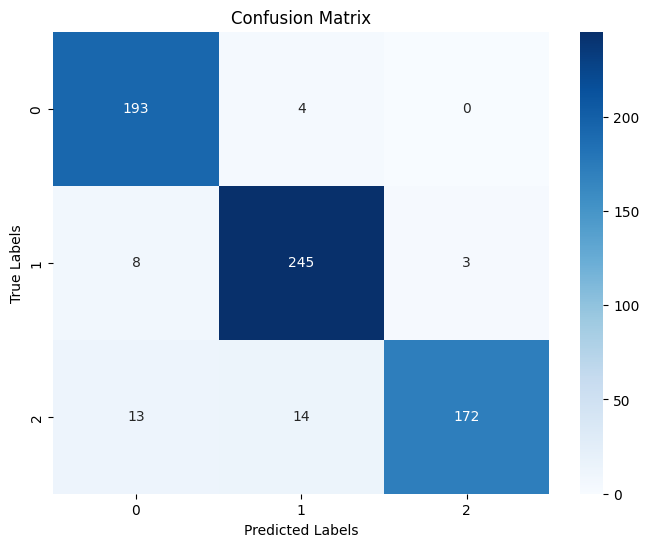

In [90]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

##### Saving the model

In [91]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-oversampled-epoch_{EPOCHS}.bin",
)

##### Loading the model

In [92]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-epoch_5.bin",
            f"bertimbau-glassdoor-reviews-oversampled-epoch_{EPOCHS}.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

##### Sample prediction

In [93]:
predict_reviews(oversampled_model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.000312
positive    0.999500
negative    0.000188
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.004402
positive    0.087040
negative    0.908558
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.998482
positive    0.000933
negative    0.000585
Name: 0, dtype: float64




#### Train freezing

In [94]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model_freezing,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer_freezing,
    EPOCHS,
    n_total_steps,
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/163, 		 loss = 0.6730
Training Batch 32/163, 		 loss = 0.3183
Training Batch 48/163, 		 loss = 0.4366
Training Batch 64/163, 		 loss = 0.1650
Training Batch 80/163, 		 loss = 0.1464
Training Batch 96/163, 		 loss = 0.3208
Training Batch 112/163, 		 loss = 0.3153
Training Batch 128/163, 		 loss = 0.2580
Training Batch 144/163, 		 loss = 0.1050
Training Batch 160/163, 		 loss = 0.0943

Evaluating Batch 16/163, 		 loss = 0.2898
Evaluating Batch 32/163, 		 loss = 0.0171

Train Loss: 0.2930625579405599, 		 Test Loss: 0.1172146555618383



-------------------- Epoch: 2/5 --------------------
Training Batch 16/163, 		 loss = 0.0542
Training Batch 32/163, 		 loss = 0.0156
Training Batch 48/163, 		 loss = 0.0192
Training Batch 64/163, 		 loss = 0.0117
Training Batch 80/163, 		 loss = 0.2419
Training Batch 96/163, 		 loss = 0.0360
Training Batch 112/163, 		 loss = 0.0087
Training Batch 128/163, 		 loss = 0.0519
Training Batch

##### Evaluating the Model

In [95]:
len(oversampled_train_losses)

5

In [96]:
len(oversampled_test_losses)

5

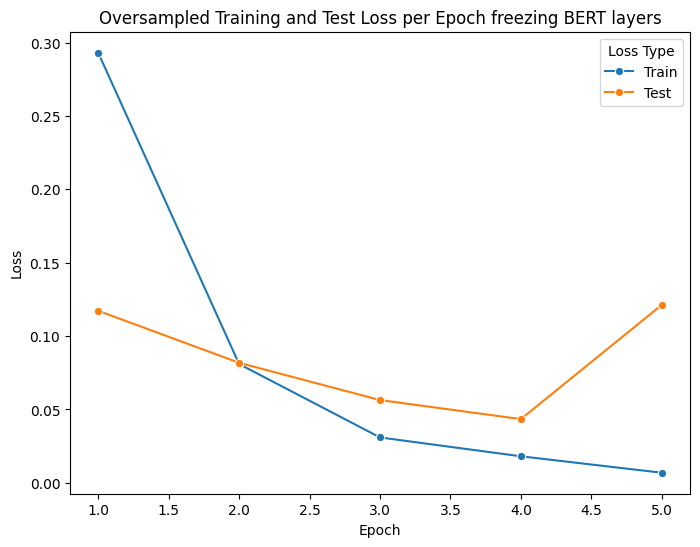

In [97]:
show_loss(
    oversampled_train_losses,
    oversampled_test_losses,
    title="Oversampled Training and Test Loss per Epoch freezing BERT layers",
)

In [113]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model_freezing, oversampled_test_loader, device
)

In [114]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       197
           1       0.92      0.98      0.95       256
           2       0.98      0.88      0.93       199

    accuracy                           0.95       652
   macro avg       0.96      0.95      0.95       652
weighted avg       0.95      0.95      0.95       652



In [100]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

0.9355828220858896


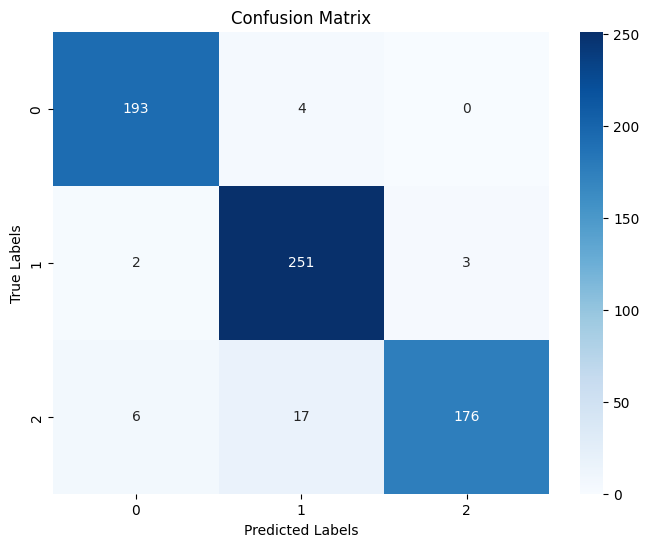

In [115]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

##### Saving the model

In [116]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-oversampled-freezing-epoch_{EPOCHS}.bin",
)

##### Loading the model

In [117]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-epoch_5.bin",
            f"bertimbau-glassdoor-reviews-oversampled-freezing-epoch_{EPOCHS}.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

##### Sample prediction

In [118]:
predict_reviews(oversampled_model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.000057
positive    0.999906
negative    0.000037
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.001182
positive    0.068035
negative    0.930783
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.999740
positive    0.000169
negative    0.000091
Name: 0, dtype: float64


